<a href="https://colab.research.google.com/github/GaikwadSandesh/NYC_taxi_prediction/blob/main/NYC_taxi_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import scipy.stats as stats
import pylab
import scipy

# modeling utilities
from scipy.stats import zscore
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split

# Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Alma_better/NYC Taxi Time Prediction/NYC Taxi Data.csv", parse_dates=['pickup_datetime'])

In [5]:
# df.head(10)

In [6]:
# df.info()

In [7]:
# df.isnull().sum()

In [8]:
# df['vendor_id'].nunique() , df['id'].nunique()

In [9]:
df.drop(columns = 'id' , inplace =True)

In [10]:
# df.describe()

#EDA

## Anomaly Detection

In [11]:
# df.shape

In [12]:
# plt.figure(figsize = (9, 7))
# plt.subplot(2,3,1)
# sns.boxplot(x=df.passenger_count)
# plt.subplot(2,3,2)
# sns.boxplot(x=df.pickup_longitude)
# plt.subplot(2,3,3)
# sns.boxplot(x=df.pickup_latitude)
# plt.subplot(2,3,4)
# sns.boxplot(x=df.dropoff_longitude)
# plt.subplot(2,3,5)
# sns.boxplot(x=df.dropoff_latitude)
# plt.subplot(2,3,6)
# sns.boxplot(x=df.trip_duration)
# plt.show()

### pickup_longitude

In [13]:
df = df[(df['pickup_longitude']<-65) & (-85<df['pickup_longitude'])]

In [14]:
# plt.figure(figsize = (15, 7))
# plt.subplot(1, 2 , 1)
# sns.histplot(x=df.pickup_longitude)
# plt.subplot(1,2 , 2)
# sns.boxplot(x=df.pickup_longitude)

In [15]:
df = df[(df['pickup_longitude']<-73.5) & (-74.5<df['pickup_longitude'])]

In [16]:
# plt.figure(figsize = (15, 7))
# plt.subplot(1, 2 , 1)
# sns.histplot(x=df.pickup_longitude)
# plt.subplot(1,2 , 2)
# sns.boxplot(x=df.pickup_longitude)

### pickup_latitude

In [17]:
df = df[(30<df['pickup_latitude']) & (df['pickup_latitude']<55)]

In [18]:
# plt.figure(figsize = (15, 7))
# plt.subplot(1, 2 , 1)
# sns.histplot(x=df.pickup_latitude)
# plt.subplot(1,2 , 2)
# sns.boxplot(x=df.pickup_latitude)

In [19]:
df = df[(40.3<df['pickup_latitude']) & (df['pickup_latitude']<41.2)]

In [20]:
# plt.figure(figsize = (15, 7))
# plt.subplot(1, 2 , 1)
# sns.histplot(x=df.pickup_latitude)
# plt.subplot(1,2 , 2)
# sns.boxplot(x=df.pickup_latitude)

### dropoff_longitude

In [21]:
# plt.figure(figsize = (15, 7))
# plt.subplot(1, 2 , 1)
# sns.histplot(x=df.dropoff_longitude)
# plt.subplot(1,2 , 2)
# sns.boxplot(x=df.dropoff_longitude)

In [22]:
df = df[(df['dropoff_longitude']<-73) & (-75<df['dropoff_longitude'])]

In [23]:
# plt.figure(figsize = (15, 7))
# plt.subplot(1, 2 , 1)
# sns.histplot(x=df.dropoff_longitude)
# plt.subplot(1,2 , 2)
# sns.boxplot(x=df.dropoff_longitude)

### dropoff_latitude

In [24]:
df = df[(30<df['dropoff_latitude']) & (df['dropoff_latitude']<55)]

In [25]:
# plt.figure(figsize = (15, 7))
# plt.subplot(1, 2 , 1)
# sns.histplot(x=df.dropoff_latitude)
# plt.subplot(1,2 , 2)
# sns.boxplot(x=df.dropoff_latitude)

In [26]:
df = df[(40<df['dropoff_latitude']) & (df['dropoff_latitude']<41.2)]

In [27]:
# plt.figure(figsize = (15, 7))
# plt.subplot(1, 2 , 1)
# sns.histplot(x=df.dropoff_latitude)
# plt.subplot(1,2 , 2)
# sns.boxplot(x=df.dropoff_latitude)

In [28]:
# sns.countplot(x=df.passenger_count )

vehical which are carring more than 6 passengers can't be cars so we will drop  values greater than 6

In [29]:
df = df[df['passenger_count']<=6]

In [30]:
df.shape

(1458527, 10)



## Feature Enginnering

In [31]:
# Not taking 'year' as feature because all trips are from year 2016 only

df['month'] = df.pickup_datetime.apply(lambda t: t.month)
df['weekday'] = df.pickup_datetime.apply(lambda t: t.weekday())
df['weekend'] = df['weekday'].apply(lambda t: 1 if t in [5,6] else 0)
df['hour'] = df.pickup_datetime.apply(lambda t: t.hour) 

# abs of delta of longitude and latitude pickup-dropoff
df['delta_longitude'] = abs(df.pickup_longitude - df.dropoff_longitude)
df['delta_latitude'] = abs(df.pickup_latitude - df.dropoff_latitude)

In [32]:
# Function to find direction in degrees (Source: https://gist.github.com/jeromer/2005586)
def get_direction(lat1, lon1, lat2, lon2):
  lon1=lon1.to_numpy()
  lat1=lat1.to_numpy()
  lon2=lon2.to_numpy()
  lat2=lat2.to_numpy()
  diff_lon = np.deg2rad(lon2-lon1)
  x = np.sin(diff_lon) * np.cos(lat2)
  y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(diff_lon))
  initial_bearing = np.arctan2(x, y)
  direction = np.degrees (initial_bearing)

  # Now we have the initial bearing but math.atan2 return values
  # from -180° to + 180° which is not what we want for a compass bearing
  # The solution is to normalize the initial bearing as shown below

  initial_bearing = np.degrees (initial_bearing)
  direction = (initial_bearing + 360) % 360
  return direction


# Haversine Formula, distance calculation (between pick-up and drop-off coordinates) 
#

def haversine(lat1, lon1, lat2, lon2):
  # convert decimal degrees to radians 
  lon1=np.deg2rad(lon1.to_numpy())
  lat1=np.deg2rad(lat1.to_numpy())
  lon2=np.deg2rad(lon2.to_numpy())
  lat2=np.deg2rad(lat2.to_numpy())
  # haversine formula 
  dlon = lon2 - lon1 
  dlat = lat2 - lat1 
  a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
  c = 2 * np.arcsin(np.sqrt(a)) 
  r = 6372.8 # Radius of earth in kilometers. Use 3956 for miles
  return np.around(c * r, decimals=2)

In [33]:
# Create columns 'direction', 'distance_km'
df['direction']   = get_direction(df['pickup_latitude'], df['pickup_longitude'], \
                                      df['dropoff_latitude'], df['dropoff_longitude'])

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'], \
                                      df['dropoff_latitude'], df['dropoff_longitude'])

In [34]:
# trip_duration
highest_allowed = df['trip_duration'].mean() + 3*df['trip_duration'].std()
lowest_allowed = 10
df = df[(df['trip_duration'] > lowest_allowed) & (df['trip_duration'] < highest_allowed)]
print(highest_allowed)

# distance_km
highest_allowed = df['distance_km'].mean() + 3*df['distance_km'].std()
lowest_allowed = 0.1
df = df[(df['distance_km'] > lowest_allowed) & (df['distance_km'] < highest_allowed)]


16670.680578068725


In [35]:
# df.info()

In [36]:
drop_columns =  ['vendor_id' , 'pickup_longitude' , 'pickup_latitude' , 'dropoff_longitude', 'dropoff_latitude' , 'store_and_fwd_flag' , 'pickup_datetime' , 'dropoff_datetime' ]

In [37]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month,weekday,weekend,hour,delta_longitude,delta_latitude,direction,distance_km
count,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06
mean,1.533679e+00,1.662811e+00,-7.397690e+01,4.075282e+01,-7.397508e+01,4.075289e+01,7.827437e+02,3.514071e+00,3.050005e+00,2.851139e-01,1.361058e+01,1.959587e-02,1.903466e-02,2.213243e+02,2.944020e+00
std,4.988646e-01,1.313738e+00,2.857262e-02,2.440131e-02,2.847346e-02,2.935633e-02,5.524500e+02,1.680412e+00,1.951502e+00,4.514688e-01,6.400973e+00,2.409687e-02,1.823966e-02,1.191064e+02,2.603827e+00
min,1.000000e+00,0.000000e+00,-7.439355e+01,4.039825e+01,-7.439851e+01,4.041617e+01,1.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e-01
25%,1.000000e+00,1.000000e+00,-7.399207e+01,4.073853e+01,-7.399139e+01,4.073706e+01,3.930000e+02,2.000000e+00,1.000000e+00,0.000000e+00,9.000000e+00,6.195068e-03,6.847382e-03,1.788373e+02,1.230000e+00
50%,2.000000e+00,1.000000e+00,-7.398203e+01,4.075479e+01,-7.397999e+01,4.075494e+01,6.460000e+02,4.000000e+00,3.000000e+00,0.000000e+00,1.400000e+01,1.229095e-02,1.335907e-02,1.802931e+02,2.050000e+00
75%,2.000000e+00,2.000000e+00,-7.396841e+01,4.076869e+01,-7.396389e+01,4.077004e+01,1.024000e+03,5.000000e+00,5.000000e+00,1.000000e+00,1.900000e+01,2.268982e-02,2.498627e-02,3.587522e+02,3.640000e+00
max,2.000000e+00,6.000000e+00,-7.354157e+01,4.115737e+01,-7.351768e+01,4.107109e+01,1.590000e+04,6.000000e+00,6.000000e+00,1.000000e+00,2.300000e+01,1.809769e-01,1.367798e-01,3.599998e+02,1.525000e+01


In [38]:
df.drop(columns = drop_columns , inplace =True)

In [39]:
df.head(5)

,passenger_count,trip_duration,month,weekday,weekend,hour,delta_longitude,delta_latitude,direction,distance_km
0,1,455,3,0,0,17,0.017525,0.002335,187.443216,1.50
1,1,663,6,6,1,0,0.019066,0.007412,177.444784,1.81
2,1,2124,1,1,0,11,0.026306,0.053852,179.515450,6.39
3,1,429,4,2,0,19,0.002228,0.013252,179.833396,1.49
4,1,435,3,5,1,13,0.000130,0.010689,180.012114,1.19


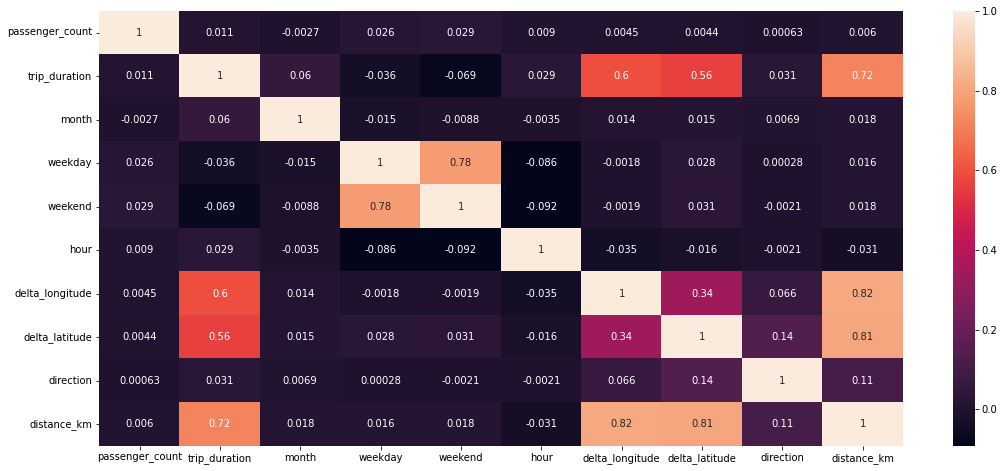

In [40]:
# correlation
plt.figure(figsize = (18,8))
corr = df.corr()
corr
sns.heatmap(corr, annot = True)

* Drop passenger_count , month , drop weekday number 
* hour as categoriacal variable  

In [41]:
drop_columns = ['passenger_count'  , 'weekday']

In [42]:
df.drop(columns = drop_columns , inplace =True)

In [43]:
# # Plot histogram of trip duration per hour
# plt.figure(figsize = (10,5))
# new_df = df.groupby('hour', as_index = False)['trip_duration'].agg(['count']).sort_values(by = 'hour', ascending = True)
# ax = sns.barplot(x=new_df.index, y=new_df['count'])
# ax.set(xlabel='Hour', ylabel='No. of trips')  
# plt.title('Number of trips per hour')
# plt.tight_layout()
# plt.show()
# del new_df

In [44]:
def rush_hours(hour):
  value = 2
  if hour in [8,9,10,11,12,13,14,15,16,17,23]:
    value =1
  elif hour in [0,1,2,3,4,5,6,7]:
    value = 0

  return value

In [45]:
df['rush_hours'] = df.hour.apply(rush_hours)

In [46]:
# # Plot histogram of trips per weekday
# plt.figure(figsize = (10,5))
# new_df = df.groupby('weekday', as_index = False)['trip_duration'].agg(['count']).sort_values(by = 'weekday', ascending = True)
# ax = sns.barplot(x=new_df.index, y=new_df['count'])
# ax.set(xlabel='weekday', ylabel='No of trips')  
# plt.title('Number of trips per weekday')
# plt.tight_layout()
# plt.show()
# del new_df

In [47]:
#df.drop(columns = ['hour'] , inplace =True)

In [48]:
df.head()

,trip_duration,month,weekend,hour,delta_longitude,delta_latitude,direction,distance_km,rush_hours
0,455,3,0,17,0.017525,0.002335,187.443216,1.50,1
1,663,6,1,0,0.019066,0.007412,177.444784,1.81,0
2,2124,1,0,11,0.026306,0.053852,179.515450,6.39,1
3,429,4,0,19,0.002228,0.013252,179.833396,1.49,2
4,435,3,1,13,0.000130,0.010689,180.012114,1.19,1


In [49]:
# # correlation
# plt.figure(figsize = (18,8))
# corr = df.corr()
# corr
# sns.heatmap(corr, annot = True)

In [50]:
drop_columns = ['delta_longitude' ,'delta_latitude']

In [51]:
df.drop(columns = drop_columns , inplace =True)

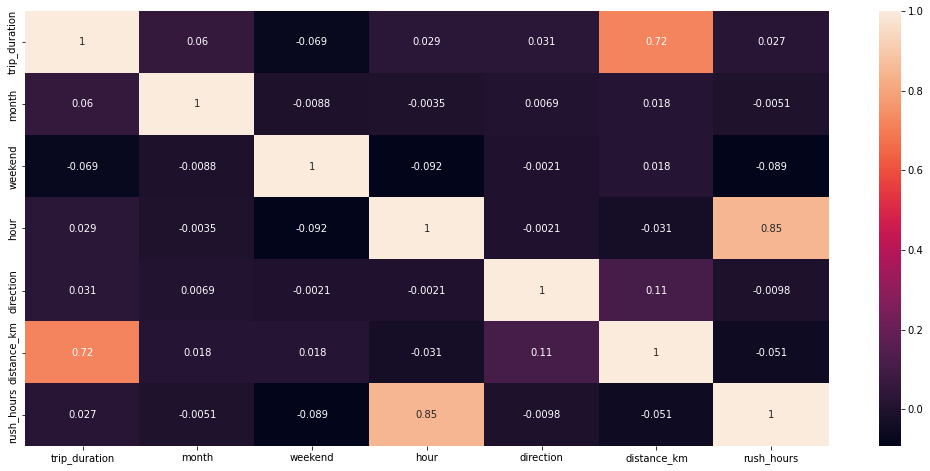

In [52]:
# correlation
plt.figure(figsize = (18,8))
corr = df.corr()
corr
sns.heatmap(corr, annot = True)

#### Distance

In [53]:
#function to return plots for the feature
def normality(data,feature):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  sns.distplot(data[feature],color = "b")
  plt.axvline(data[feature].mean(),color = "k",
            linestyle = "dashed",label = 'mean')
  plt.subplot(1,2,2)
  stats.probplot(data[feature],plot=pylab)
  plt.show()
  print('skewness  : ' , data[feature].skew() )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


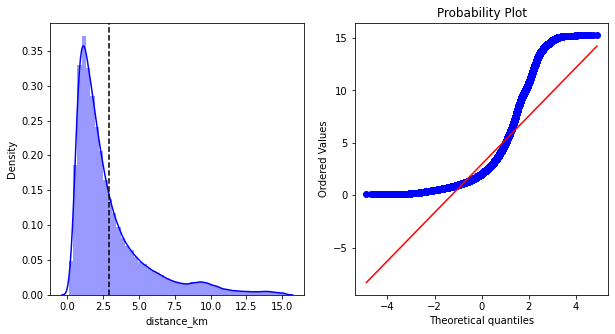

skewness  :  1.9517243542550862


In [54]:
normality(df , 'distance_km')

In [55]:
df['distance_Boxcox'],parameters=stats.boxcox(df['distance_km'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


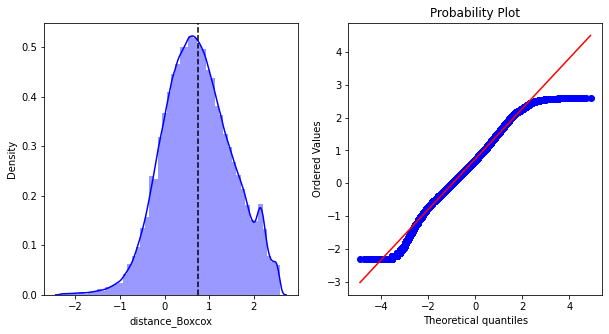

skewness  :  0.0012122340625846646


In [56]:
normality(df , 'distance_Boxcox')

### Trip duration

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


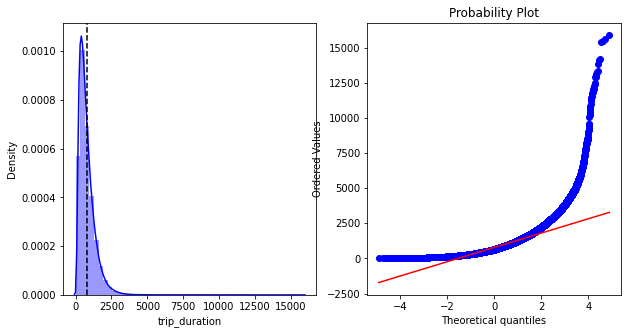

skewness  :  2.08118809062355


In [57]:
normality(df , 'trip_duration')

In [58]:
df['duration_Boxcox'],parameters=stats.boxcox(df['trip_duration'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


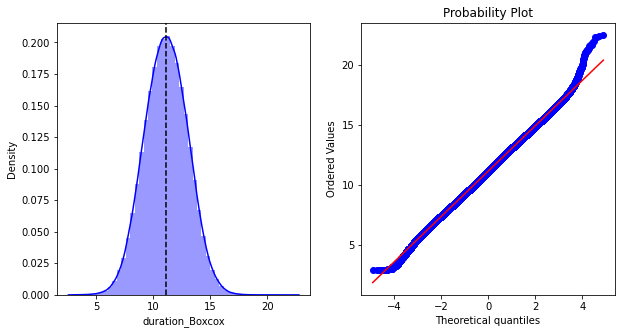

skewness  :  -0.0021837506737579933


In [59]:
normality(df , 'duration_Boxcox')

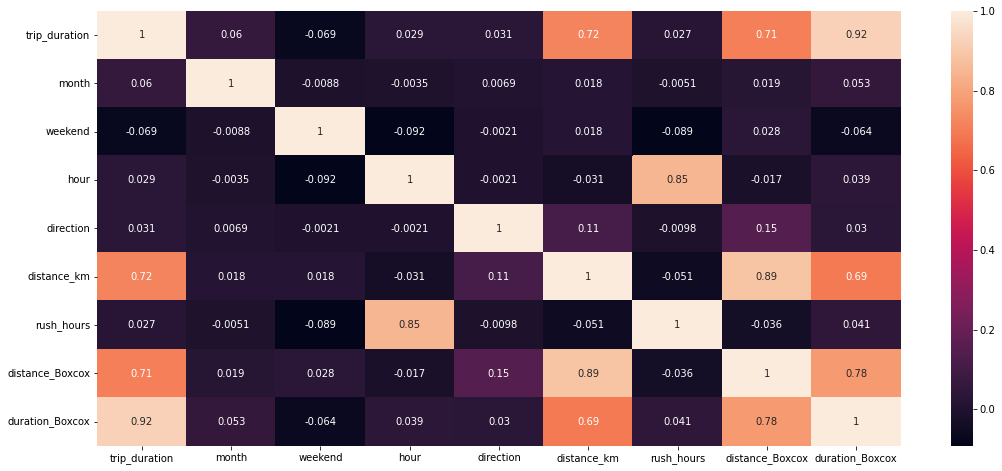

In [60]:
# correlation
plt.figure(figsize = (18,8))
corr = df.corr()
corr
sns.heatmap(corr, annot = True)

* only numerical parameters to consider is Distance Boxcox
* rush_hour and weekend are two categorical variable
* we will perfor boxcox on trrip duration

# Modeling

In [61]:
def evaluation_metrics(y_test, y_pred):
  
  r2 = round(r2_score(y_test, y_pred), 2)
  print("R2 on test data:" ,r2)

  MSE  = round(mean_squared_error(y_test, y_pred), 2)
  print("MSE :" , MSE)

  RMSE = round(np.sqrt(MSE), 2)
  print("RMSE :" ,RMSE)

  MAE = round(mean_absolute_error(y_test, y_pred), 2) 
  print("MAE :" ,MAE)

## Linear Regression

### Train test split

In [62]:
# df.info()

In [63]:
columns_to_keep = ['distance_km' , 'weekend' , 'rush_hours' , 'hour']
X = df[columns_to_keep]
y = df['trip_duration'].to_frame()

In [64]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.3, random_state = 42 , stratify = X.hour) 
print(X_train.shape)
print(X_test.shape)

(979058, 4)
(419597, 4)


In [65]:
X_train['distance_Boxcox'], dist_boxcox_param = stats.boxcox(X_train['distance_km'])
y_train['duration_Boxcox'], dura_boxcox_param = stats.boxcox(y_train['trip_duration'])

In [66]:
y_train.drop(columns = 'trip_duration' , inplace =True)

In [67]:
# normality(X_train , 'distance_Boxcox')

In [68]:
# normality(y_train , 'duration_Boxcox')

In [69]:
X_test['distance_Boxcox'] = stats.boxcox(X_test['distance_km'] , dist_boxcox_param)
# y_test['duration_Boxcox'] = stats.boxcox(y_test['trip_duration'] , dura_boxcox_param)

In [70]:
# normality(X_test , 'distance_Boxcox')

In [71]:
# normality(y_test , 'duration_Boxcox')

In [72]:
X_test = X_test.drop(columns = ['distance_km' , 'hour'])
X_train = X_train.drop(columns = ['distance_km' , 'hour'])
# y_test.drop(columns = 'trip_duration' , inplace =True)

### Unreguarized

In [73]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [74]:
reg.coef_

array([[-0.33749605,  0.17175617,  1.91564202]])

In [75]:
y_pred= scipy.special.inv_boxcox(y_pred , dura_boxcox_param)
# y_test= scipy.special.inv_boxcox(y_test , dura_boxcox_param)
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.55
MSE : 138919.77
RMSE : 372.72
MAE : 241.08


### Regularized

#### Lasso regression

In [76]:
### Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-3,1e-2,1e-1,1,5,10,20]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)
y_pred = lasso_regressor.predict(X_test)

In [77]:
y_pred= scipy.special.inv_boxcox(y_pred , dura_boxcox_param)
# y_test= scipy.special.inv_boxcox(y_test , dura_boxcox_param)
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.55
MSE : 138960.83
RMSE : 372.77
MAE : 241.07


#### Ridge regression

In [78]:
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters = {'alpha': [1e-3,1e-2,1,5,10,20]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_regressor.fit(X_train,y_train)
y_pred = ridge_regressor.predict(X_test)

In [79]:
y_pred= scipy.special.inv_boxcox(y_pred , dura_boxcox_param)
# y_test= scipy.special.inv_boxcox(y_test , dura_boxcox_param)
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.55
MSE : 138919.83
RMSE : 372.72
MAE : 241.08


## Decision Tree regression

In [80]:
columns_to_keep = ['distance_km' , 'weekend' , 'rush_hours' , 'hour']
X = df[columns_to_keep]
y = df['trip_duration']

In [81]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.3, random_state = 42 , stratify = X.hour) 
print(X_train.shape)
print(X_test.shape)

(979058, 4)
(419597, 4)


In [82]:
X_test = X_test.drop(columns = ['hour'])
X_train = X_train.drop(columns = ['hour'])

### Decision Tree

In [83]:
param_grid = {"min_samples_split": [2 , 4 , 10 ],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [10 , 20],
              "max_leaf_nodes": [20, 50],
              }

dtm = DecisionTreeRegressor()
grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=5)
grid_cv_dtm.fit(X_train,y_train)
y_pred = grid_cv_dtm.predict(X_test)

In [84]:
# y_pred= scipy.special.inv_boxcox(y_pred , dura_boxcox_param)
# y_test= scipy.special.inv_boxcox(y_test , dura_boxcox_param)
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.59
MSE : 124154.54
RMSE : 352.36
MAE : 234.81


In [85]:
grid_cv_dtm.best_estimator_

DecisionTreeRegressor(max_depth=8, max_leaf_nodes=50, min_samples_leaf=10)

### Random Forest

In [86]:
# Create the parameter grid based on the results of random search
from sklearn.ensemble import RandomForestRegressor 
param_grid = {'n_estimators': [50], "min_samples_leaf": [5 ], "max_leaf_nodes": [20, 50], 
              "min_samples_split": [2 , 4 ] ,
 'max_depth': [6 ,10, 20], 'bootstrap': [True, False]}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = 1, verbose = 1)
grid_search_rf.fit(X_train,y_train)
y_pred = grid_search_rf.predict(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [87]:
grid_search_rf.best_estimator_

RandomForestRegressor(max_depth=10, max_leaf_nodes=50, min_samples_leaf=5,
                      min_samples_split=4, n_estimators=50)

In [89]:
# y_pred= scipy.special.inv_boxcox(y_pred , dura_boxcox_param)
# y_test= scipy.special.inv_boxcox(y_test , dura_boxcox_param)
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.6
MSE : 123376.66
RMSE : 351.25
MAE : 233.86
